In [1]:
# ============================================================================
#
# ============================================================================

# Step 1: Install compatible NumPy version
import sys
!{sys.executable} -m pip install numpy==2.0.2 -q

# Step 2: Reinstall scikit-learn with the correct NumPy
!{sys.executable} -m pip install --force-reinstall --no-cache-dir scikit-learn==1.6.1 -q

# Step 3: Install other libraries
!pip install -q librosa soundfile wordcloud gradio

print("✓ Packages installed, now importing...\n")

# Import everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import soundfile as sf
import os
from glob import glob

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc, roc_auc_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import sklearn

print("✓ All libraries imported successfully!")
print(f"\n📦 Versions:")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  Scikit-learn: {sklearn.__version__}")
print(f"  Librosa: {librosa.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 213.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 142.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 297.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 113.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 re

In [2]:
!pip install -q git+https://github.com/speechbrain/speechbrain.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 17.4 MB/s eta 0:00:00


In [3]:



# Cell 2: Imports, settings, and paths
import os, glob, math, pickle, tempfile, warnings, random, time
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import librosa, soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.neighbors import NearestNeighbors

import torch
from speechbrain.pretrained import EncoderClassifier

warnings.filterwarnings("ignore")
sns.set()

from google.colab import drive
drive.mount('/content/drive')

AUDIO_ROOT = "/content/drive/MyDrive/CS316 PROJECT/audio"
QURAN_CSV_PATH = "/content/drive/MyDrive/CS316 PROJECT/quran_full.csv"
EMBED_DB_PATH = "/content/embeddings_db.pkl"
CLASSIFIER_PATH = "/content/reciter_classifier.pkl"
CONTENT_INDEX_PATH = "/content/content_index.pkl"

SR = 16000
CHUNK_SEC = 6.0
CHUNK_HOP = 3.0
N_MFCC = 40
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)
print("Audio folder exists:", os.path.exists(AUDIO_ROOT))
print("CSV file exists:", os.path.exists(QURAN_CSV_PATH))


DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


Mounted at /content/drive
Device: cuda
Audio folder exists: True
CSV file exists: True


In [4]:
# Cell 3: Load quran_full.csv and prepare verse counts
if not os.path.exists(QURAN_CSV_PATH):
    raise FileNotFoundError(f"quran_full.csv not found at {QURAN_CSV_PATH}. Upload it or change the path.")

quran_df = pd.read_csv(QURAN_CSV_PATH, index_col=0)
expected_cols = ["Chapter Name", "Chapter Number", "Verse Number", "Arabic Text"]
if not all(c in quran_df.columns for c in expected_cols):
    raise ValueError(f"CSV missing expected columns. Found: {list(quran_df.columns)}; expected: {expected_cols}")

verses_per_surah = quran_df.groupby("Chapter Number")["Verse Number"].max().to_dict()
print("Loaded quran_full.csv, sample:", list(verses_per_surah.items())[:5])


Loaded quran_full.csv, sample: [(1, 7), (2, 286), (3, 200), (4, 176), (5, 120)]


In [5]:
# Cell 5: Whisper for transcription
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration

print("Loading SpeechBrain ECAPA speaker model...")
spk_model = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": DEVICE}
)
spk_model.to(DEVICE)
spk_model.eval()
print("Speaker model loaded.")

# Load Whisper for Arabic transcription
print("Loading Whisper model for Arabic transcription...")
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
whisper_model.to(DEVICE)
whisper_model.eval()
print("Whisper model loaded.")

def list_reciter_files(audio_root=AUDIO_ROOT):
    """Return list of (reciter_name, surah_number, filepath)"""
    files = []
    if not os.path.exists(audio_root):
        return files
    for reciter_dir in sorted(os.listdir(audio_root)):
        reciter_path = os.path.join(audio_root, reciter_dir)
        if not os.path.isdir(reciter_path):
            continue
        for ext in ("mp3","wav","flac","ogg","m4a"):
            for f in glob.glob(os.path.join(reciter_path, f"*.{ext}")):
                name = os.path.splitext(os.path.basename(f))[0]
                try:
                    surah_num = int(name)
                except:
                    try:
                        surah_num = int(name.lstrip("0"))
                    except:
                        continue
                files.append((reciter_dir, surah_num, f))
    return files

def load_audio_file(path, sr=SR):
    y, _sr = librosa.load(path, sr=sr, mono=True)
    return y, sr

def compute_mfcc_embedding(y, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mean = mfcc.mean(axis=1)
    std = mfcc.std(axis=1)
    return np.concatenate([mean, std])

def compute_speaker_embedding(y, sr=SR):
    wav = torch.tensor(y, dtype=torch.float32).to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        out = spk_model.encode_batch(wav)
    if isinstance(out, tuple):
        emb = out[0]
    else:
        emb = out
    emb = emb.squeeze().cpu().numpy()
    return emb

def transcribe_audio(y, sr=SR):
    """Transcribe audio to Arabic text using Whisper"""
    # Resample if needed (Whisper expects 16kHz)
    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    # Process audio
    input_features = whisper_processor(
        y,
        sampling_rate=sr,
        return_tensors="pt"
    ).input_features.to(DEVICE)

    # Generate transcription
    with torch.no_grad():
        predicted_ids = whisper_model.generate(
            input_features,
            language="ar",  # Force Arabic
            task="transcribe"
        )

    # Decode transcription
    transcription = whisper_processor.batch_decode(
        predicted_ids,
        skip_special_tokens=True
    )[0]

    return transcription.strip()

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Loading SpeechBrain ECAPA speaker model...


hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

Speaker model loaded.
Loading Whisper model for Arabic transcription...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Whisper model loaded.


In [6]:
#Text matching utilities
from difflib import SequenceMatcher
import re

def normalize_arabic_text(text):
    """Normalize Arabic text for better matching"""
    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
    # Normalize alef variations
    text = re.sub(r'[إأآا]', 'ا', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text.strip()

def find_best_match(transcribed_text, quran_df, top_k=5):
    """
    Find best matching verses in Quran using fuzzy text matching
    Returns list of (surah, ayah, similarity_score, arabic_text)
    """
    normalized_input = normalize_arabic_text(transcribed_text)

    matches = []
    for idx, row in quran_df.iterrows():
        verse_text = normalize_arabic_text(row['Arabic Text'])

        # Calculate similarity
        similarity = SequenceMatcher(None, normalized_input, verse_text).ratio()

        # Also check if input is substring of verse (for partial matches)
        if normalized_input in verse_text:
            similarity = max(similarity, 0.9)

        matches.append({
            'surah': int(row['Chapter Number']),
            'surah_name': row['Chapter Name'],
            'ayah': int(row['Verse Number']),
            'similarity': similarity,
            'text': row['Arabic Text']
        })

    # Sort by similarity and return top k
    matches.sort(key=lambda x: x['similarity'], reverse=True)
    return matches[:top_k]

In [7]:
# Cell 6: Build embedding DB with transcriptions (NO CHUNKS)
def build_db(audio_root=AUDIO_ROOT, rebuild=False):
    if os.path.exists(EMBED_DB_PATH) and not rebuild:
        print("Loading existing DB:", EMBED_DB_PATH)
        return pickle.load(open(EMBED_DB_PATH, "rb"))

    files = list_reciter_files(audio_root)
    print(f"Found {len(files)} files across reciters.")
    records = []

    for i, (reciter, surah_num, fpath) in enumerate(files):
        try:
            y, sr = load_audio_file(fpath)
        except Exception as e:
            print("Failed to load:", fpath, e)
            continue

        duration = len(y)/sr

        # Speaker embedding (for reciter identification)
        try:
            spk_emb = compute_speaker_embedding(y, sr)
        except Exception as e:
            print("SPK emb failed for", fpath, e)
            continue

        # Transcribe full surah audio
        try:
            print(f"Transcribing {reciter} - Surah {surah_num}... ({duration:.1f}s)")
            transcription = transcribe_audio(y, sr)
            print(f"  → {transcription[:100]}...")
        except Exception as e:
            print("Transcription failed for", fpath, e)
            transcription = ""

        records.append({
            "reciter": reciter,
            "surah": surah_num,
            "path": fpath,
            "duration": duration,
            "spk_emb": spk_emb,
            "transcription": transcription,
            "ground_truth_surah": surah_num  # Store known surah number
        })

        if (i+1) % 5 == 0:
            print(f"Processed {i+1}/{len(files)}")

    db = {"records": records}
    pickle.dump(db, open(EMBED_DB_PATH, "wb"))
    print("Saved DB to", EMBED_DB_PATH)
    return db

# Run build (set rebuild=True to include transcriptions)
db = build_db(AUDIO_ROOT, rebuild=True)
print("Records in DB:", len(db["records"]))

Found 22 files across reciters.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcribing abdulbasit_abdulsamad - Surah 67... (853.3s)
  → بسم الله الرحمن الرحيم تبارك الأذي بيده الملك وعلى كل شيء قلير...
Transcribing abdulbasit_abdulsamad - Surah 109... (91.1s)
  → بسم الله الرحمن الرحيم قل يا أيها الكافرون...
Transcribing abdulbasit_abdulsamad - Surah 110... (62.1s)
  → بسم الله الرحمن الرحيم إذا جاء نصر الله والفتح...
Transcribing abdulbasit_abdulsamad - Surah 112... (41.4s)
  → بسم الله الرحمن الرحيب قله الله أحد الله الصمد لم يلد ولم يولد...
Transcribing abdulbasit_abdulsamad - Surah 113... (63.6s)
  → بسم الله الرحمن الرحيم...
Processed 5/22
Transcribing abdulbasit_abdulsamad - Surah 114... (83.0s)
  → 2. بسم الله الرحمن الرحيم 3. قل أعوذ برب الناس 4. ملك الناس...
Transcribing abdulrahman_sudias - Surah 112... (14.0s)
  → بسم الله الرحمن الرحيم...
Transcribing abdulrahman_sudias - Surah 110... (23.5s)
  → بسم الله الرحمن الرحيم...
Transcribing abdulrahman_sudias - Surah 111... (25.7s)
  → بسم الله الرحمن الرحيم تكبت يدى أبي لهبي وتبى ما أرنا عنه ماله وما 

Number of unique reciters: 4
Top reciters by file count:
 [('mishary_al_afasy', 7), ('abdulbasit_abdulsamad', 6), ('abdulrahman_sudias', 6), ('islam_sobhi', 3)]


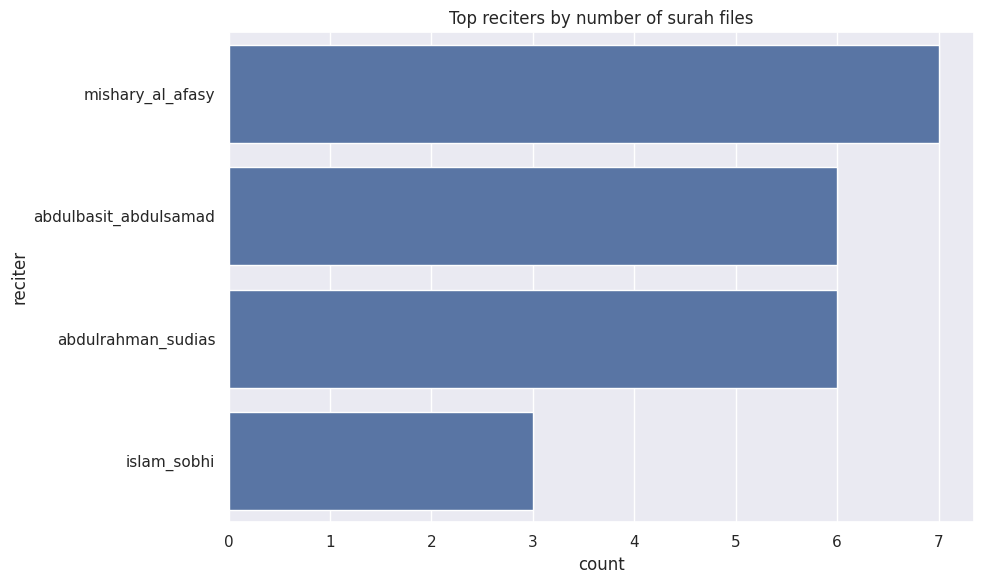


Example record keys: dict_keys(['reciter', 'surah', 'path', 'duration', 'spk_emb', 'transcription', 'ground_truth_surah'])
Reciter: abdulbasit_abdulsamad Surah: 67 Duration: 853.3420625
Transcription sample: بسم الله الرحمن الرحيم تبارك الأذي بيده الملك وعلى كل شيء قلير


In [8]:
# Cell 7: EDA - reciter counts and example record
from collections import Counter
reciter_counts = Counter([r["reciter"] for r in db["records"]])
print("Number of unique reciters:", len(reciter_counts))
print("Top reciters by file count:\n", reciter_counts.most_common(10))

# barplot top reciters
top = reciter_counts.most_common(20)
if top:
    df_top = pd.DataFrame(top, columns=["reciter","count"])
    plt.figure(figsize=(10,6))
    sns.barplot(y="reciter", x="count", data=df_top)
    plt.title("Top reciters by number of surah files")
    plt.tight_layout()
    plt.show()

# Show example record
if len(db["records"])>0:
    example = db["records"][0]
    print("\nExample record keys:", example.keys())
    print("Reciter:", example["reciter"], "Surah:", example["surah"], "Duration:", example["duration"])
    print("Transcription sample:", example["transcription"][:200] if example["transcription"] else "None")

Unique reciters: 4
Saved classifier to /content/reciter_classifier.pkl
Val metrics -> acc=1.000, prec=1.000, rec=1.000, f1=1.000


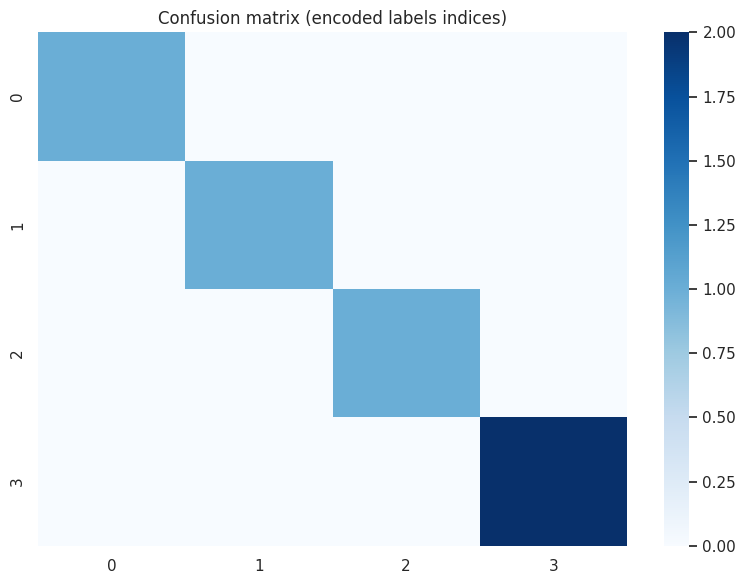

In [9]:
# Cell 8: Train reciter classifier (speaker embeddings -> reciter)
# Build X,y
X = []
y = []
for rec in db["records"]:
    X.append(rec["spk_emb"])
    y.append(rec["reciter"])
X = np.vstack(X)
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Unique reciters:", len(le.classes_))

# If very few samples per class, stratify will fail; guard against that
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED)
except Exception:
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=SEED)

clf = LogisticRegression(max_iter=2000, multi_class="multinomial")
clf.fit(X_train, y_train)
# Save classifier + label encoder
pickle.dump({"clf": clf, "le": le}, open(CLASSIFIER_PATH, "wb"))
print("Saved classifier to", CLASSIFIER_PATH)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)
print(f"Val metrics -> acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")

# Confusion matrix for top-K reciters (plot)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion matrix (encoded labels indices)")
plt.tight_layout()
plt.show()


In [10]:
# Cell 10: Inference with transcription and text matching
model_pack = pickle.load(open(CLASSIFIER_PATH, "rb"))
clf = model_pack["clf"]
le = model_pack["le"]

def predict_from_clip(path, top_k=3, max_duration=30):
    """
    Predict reciter and identify Surah/Ayah from audio clip

    Args:
        path: Audio file path
        top_k: Number of top predictions to return
        max_duration: Maximum audio duration to process (seconds)
    """
    y, sr = load_audio_file(path)

    # Limit to max_duration to avoid memory issues, but use enough for transcription
    if len(y) > max_duration * sr:
        print(f"Audio is {len(y)/sr:.1f}s, limiting to {max_duration}s for processing")
        y = y[:int(max_duration * sr)]

    duration = len(y) / sr
    print(f"Processing {duration:.1f}s of audio...")

    # 1. RECITER IDENTIFICATION (using speaker embedding)
    spk_emb = compute_speaker_embedding(y, sr)
    probs = clf.predict_proba(spk_emb.reshape(1,-1))[0]
    classes = le.inverse_transform(np.arange(len(probs)))
    top_idx = np.argsort(probs)[::-1][:top_k]
    reciter_preds = [(classes[i], float(probs[i])) for i in top_idx]

    # 2. TRANSCRIPTION (convert audio to text)
    try:
        print("Transcribing audio...")
        transcription = transcribe_audio(y, sr)
        print(f"Transcribed: {transcription[:100]}...")
    except Exception as e:
        print("Transcription error:", e)
        transcription = "Error during transcription"
        return reciter_preds, transcription, []

    # 3. TEXT MATCHING (find matching verses in Quran)
    try:
        print("Matching with Quran verses...")
        matches = find_best_match(transcription, quran_df, top_k=5)
    except Exception as e:
        print("Matching error:", e)
        matches = []

    return reciter_preds, transcription, matches

# Test with first file in database
if len(db["records"]) > 0:
    test_file = db["records"][0]["path"]
    print("="*80)
    print("TESTING INFERENCE")
    print("="*80)
    print("Test file:", test_file)
    print("Ground truth - Reciter:", db["records"][0]["reciter"],
          "Surah:", db["records"][0]["surah"])
    print()

    rp, transcription, matches = predict_from_clip(test_file, top_k=3, max_duration=20)

    print("\n" + "="*80)
    print("RESULTS")
    print("="*80)
    print("\n1. RECITER PREDICTIONS:")
    for r, p in rp:
        print(f"   {r}: {p:.1%}")

    print(f"\n2. TRANSCRIPTION:\n   {transcription}")

    print("\n3. TOP MATCHED VERSES:")
    if matches:
        for i, m in enumerate(matches[:3], 1):
            print(f"\n   Match {i}:")
            print(f"   - Surah {m['surah']:3d} ({m['surah_name']}), Ayah {m['ayah']}")
            print(f"   - Similarity: {m['similarity']:.1%}")
            print(f"   - Text: {m['text'][:80]}...")
    else:
        print("   No matches found")
else:
    print("DB empty: no test.")

TESTING INFERENCE
Test file: /content/drive/MyDrive/CS316 PROJECT/audio/abdulbasit_abdulsamad/067.mp3
Ground truth - Reciter: abdulbasit_abdulsamad Surah: 67

Audio is 853.3s, limiting to 20s for processing
Processing 20.0s of audio...
Transcribing audio...
Transcribed: بسم الله الرحمن الرحيم تبارك الذي بيده الملك وهو على...
Matching with Quran verses...

RESULTS

1. RECITER PREDICTIONS:
   abdulbasit_abdulsamad: 100.0%
   abdulrahman_sudias: 0.0%
   mishary_al_afasy: 0.0%

2. TRANSCRIPTION:
   بسم الله الرحمن الرحيم تبارك الذي بيده الملك وهو على

3. TOP MATCHED VERSES:

   Match 1:
   - Surah  67 (الملك), Ayah 1
   - Similarity: 88.9%
   - Text: بِسْمِ اللَّهِ الرَّحْمَـٰنِ الرَّحِيمِ تَبَارَكَ الَّذِي بِيَدِهِ الْمُلْكُ وَه...

   Match 2:
   - Surah  73 (المزمل), Ayah 1
   - Similarity: 73.3%
   - Text: بِسْمِ اللَّهِ الرَّحْمَـٰنِ الرَّحِيمِ يَا أَيُّهَا الْمُزَّمِّلُ...

   Match 3:
   - Surah  87 (الأعلى), Ayah 1
   - Similarity: 72.3%
   - Text: بِسْمِ اللَّهِ الرَّحْمَـٰنِ الرّ

In [11]:
#Enhanced text matching with substring detection
from difflib import SequenceMatcher
import re

def normalize_arabic_text(text):
    """Normalize Arabic text for better matching"""
    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
    # Normalize alef variations
    text = re.sub(r'[إأآا]', 'ا', text)
    # Normalize hamza
    text = re.sub(r'[ؤئ]', 'ء', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text.strip()

def find_best_match(transcribed_text, quran_df, top_k=5):
    """
    Find best matching verses using multiple strategies
    """
    if not transcribed_text or transcribed_text == "Error during transcription":
        return []

    normalized_input = normalize_arabic_text(transcribed_text)
    input_words = set(normalized_input.split())

    matches = []

    for idx, row in quran_df.iterrows():
        verse_text = normalize_arabic_text(row['Arabic Text'])
        verse_words = set(verse_text.split())

        # Strategy 1: Sequence matching (overall similarity)
        seq_similarity = SequenceMatcher(None, normalized_input, verse_text).ratio()

        # Strategy 2: Word overlap (handle partial verses)
        if input_words and verse_words:
            word_overlap = len(input_words & verse_words) / len(input_words)
        else:
            word_overlap = 0

        # Strategy 3: Substring matching (for continuous segments)
        substring_score = 0
        if normalized_input in verse_text:
            substring_score = 1.0
        elif len(normalized_input) > 20:  # Check if substantial portion matches
            # Check if verse contains substantial part of input
            words_to_check = min(5, len(input_words))
            for i in range(len(input_words) - words_to_check + 1):
                segment = ' '.join(list(input_words)[i:i+words_to_check])
                if segment in verse_text:
                    substring_score = 0.85
                    break

        # Combined score (weighted)
        final_score = (
            0.4 * seq_similarity +
            0.4 * word_overlap +
            0.2 * substring_score
        )

        matches.append({
            'surah': int(row['Chapter Number']),
            'surah_name': row['Chapter Name'],
            'ayah': int(row['Verse Number']),
            'similarity': final_score,
            'text': row['Arabic Text'],
            'seq_sim': seq_similarity,
            'word_overlap': word_overlap,
            'substring': substring_score
        })

    # Sort by similarity
    matches.sort(key=lambda x: x['similarity'], reverse=True)

    return matches[:top_k]

print("Enhanced text matching functions loaded.")

Enhanced text matching functions loaded.


In [12]:
import requests

def get_tafsir(surah, ayah, tafsir_type="ar.muyassar"):
    url = f"https://api.alquran.cloud/v1/ayah/{surah}:{ayah}/{tafsir_type}"
    try:
        r = requests.get(url)
        data = r.json()
        if data.get("status") == "OK":
            return data["data"]["text"]
        return "Tafsir not available."
    except Exception as e:
        return f"Error fetching tafsir: {e}"


In [13]:

def infer_gradio(file_path):
    try:
        # Process with up to 30 seconds of audio for better transcription
        rec_preds, transcription, matches = predict_from_clip(
            file_path,
            top_k=3,
            max_duration=30
        )

        # -----------------------------------------
        # 🎤 RECITER IDENTIFICATION
        # -----------------------------------------
        reciter_text = "🎤 RECITER IDENTIFICATION:\n\n"
        for i, (r, p) in enumerate(rec_preds, 1):
            reciter_text += f"{i}. {r.replace('_', ' ').title()}: {p:.1%}\n"

        # -----------------------------------------
        # 📝 TRANSCRIPTION + VERSE DETECTION
        # -----------------------------------------
        matches_text = f"📝 TRANSCRIPTION:\n{transcription}\n\n"
        matches_text += "="*60 + "\n"
        matches_text += "📖 IDENTIFIED VERSES + TAFSIR:\n\n"

        # If matches were found
        if matches:
            for i, m in enumerate(matches[:3], 1):
                surah = m["surah"]
                ayah = m["ayah"]

                # Fetch Tafsir
                tafsir = get_tafsir(surah, ayah)

                # Add to text output
                matches_text += (
                    f"{i}. Surah {surah} - {m['surah_name']}, Ayah {ayah}\n"
                    f"   Confidence: {m['similarity']:.1%}\n"
                    f"   (Seq:{m['seq_sim']:.2f} | Words:{m['word_overlap']:.2f} | Match:{m['substring']:.2f})\n"
                    f"   Text: {m['text'][:100]}...\n\n"
                    f"📚 **Tafsir (Muyassar):**\n{tafsir}\n"
                    f"{'-'*60}\n\n"
                )
        else:
            matches_text += (
                "⚠️ No matching verses found. Please ensure:\n"
                "   - Audio contains clear Quran recitation\n"
                "   - Audio is 5–10 seconds minimum\n"
                "   - Audio quality is clear\n"
            )

        return reciter_text, matches_text

    except Exception as e:
        import traceback
        error_msg = f"❌ ERROR: {str(e)}\n\n"
        error_msg += "Traceback:\n" + traceback.format_exc()
        return error_msg, ""


# -------------------------------
# GRADIO INTERFACE
# -------------------------------

demo = gr.Interface(
    fn=infer_gradio,
    inputs=gr.Audio(
        type="filepath",
        label="Upload Quran Recitation (5-30 seconds recommended)"
    ),
    outputs=[
        gr.Textbox(label="Reciter Identification", lines=5),
        gr.Textbox(label="Surah, Ayah & Tafsir", lines=25)
    ],
    title="🕌 Quran Reciter & Verse Identifier (with Tafsir)",
    description="""
    Upload an audio file of Quran recitation to:
    1. Identify the reciter with high accuracy
    2. Detect which Surah and Ayah is recited
    3. Display Tafsir Al-Muyassar for the detected Ayah

    **Tips for best results:**
    - Use clear, good-quality audio
    - Audio should be 5-30 seconds long
    - Longer clips improve transcription accuracy
    """,
    examples=None,
    cache_examples=False
)

demo.launch(share=True, inbrowser=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7fda65e8d930508bc0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
